In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import ares

In [12]:
#loading the EDGES data (the e subscipt is related to EDGES)
data_1 = pd.read_csv('data_1.csv')
freq_e = data_1.iloc[:,0] #frequency, MHz
data_e = data_1.iloc[:,6] #model, mK
model_e = data_1.iloc[:,5] #model, mK

#Changing the axis from frequency to redshift
v_0 = 1420 #MHz, frequency of 21cm line
z_e = (v_0/freq_e)-1 #conversion of frequency to redshift

#converting the data from mK to K
data_e = data_e*1000
model_e = model_e*1000

In [13]:
edges_one = pd.read_csv('curves_one_sigma_edges.gz', sep = " ", header= None)
mock_one = pd.read_csv('curves_one_sigma_mock.gz', sep = " ", header= None)
edges_two = pd.read_csv('curves_two_sigma_edges.gz', sep = " ", header= None)
mock_two = pd.read_csv('curves_two_sigma_mock.gz', sep = " ", header= None)
edges_one = edges_one.values
mock_one = mock_one.values
edges_two = edges_two.values
mock_two = mock_two.values

In [14]:
def dict_to_list(d): #converts dictionary to two lists (key and value)
    #d must be a dictionary containing the value of parameters and their names
    key = list(d.keys())
    value = list(d.values())
    return value, key

def list_to_dict(value, key): #converts two lists (key and value) to a dictionary
    #value is a list of parameters' values
    #key is a list of parameters' names
    return dict(zip(key, value))

def call_ares (params, redshifts): 
    #params should be a dictionary
    
    sim = ares.simulations.Global21cm(**params, verbose=False, progress_bar=False)
    sim.run()
    z = sim.history['z'][::-1]
    dTb = sim.history['dTb'][::-1]
    z = z[z<50]
    dTb = dTb[:len(z)]
    spline = CubicSpline(z, dTb)
    
    return spline(redshifts)

def chisquare (pars, data, Ninv): #returns the chi-square of two 21cm curves - err can be a number/array   
    try:
        pred = call_ares(list_to_dict(pars, key), z_e)
        r = data-pred
        chisq = r.T@Ninv@r
    except:
        chisq = 1E10
    return chisq

In [15]:
#edges fit and parameters
dict_edges = {'pop_rad_yield_0_': 4.54933009e+03, 'pop_rad_yield_2_': 2.47592394e+03, 'fesc': 3.70100011e-01, 'fX': 1.36397790e-01}
params_fit_edges, key = dict_to_list(dict_edges)
noise_edges = np.ones(len(z_e))*10 #mk
fit_curve_edges = call_ares(list_to_dict(params_fit_edges, key), z_e)

#mock data fit and parameters
params_true_mock = [1E4, 1E3, 0.1, 0.1]
params_fit_mock = [1.00000112E4, 1.00028045E3, 9.99804682E-2, 9.99997672E-2]
noise_mock = np.ones(len(z_e))*1E-3 #mk
true_curve_mock = call_ares(list_to_dict(params_true_mock, key), z_e)
fit_curve_mock = call_ares(list_to_dict(params_fit_mock, key), z_e)

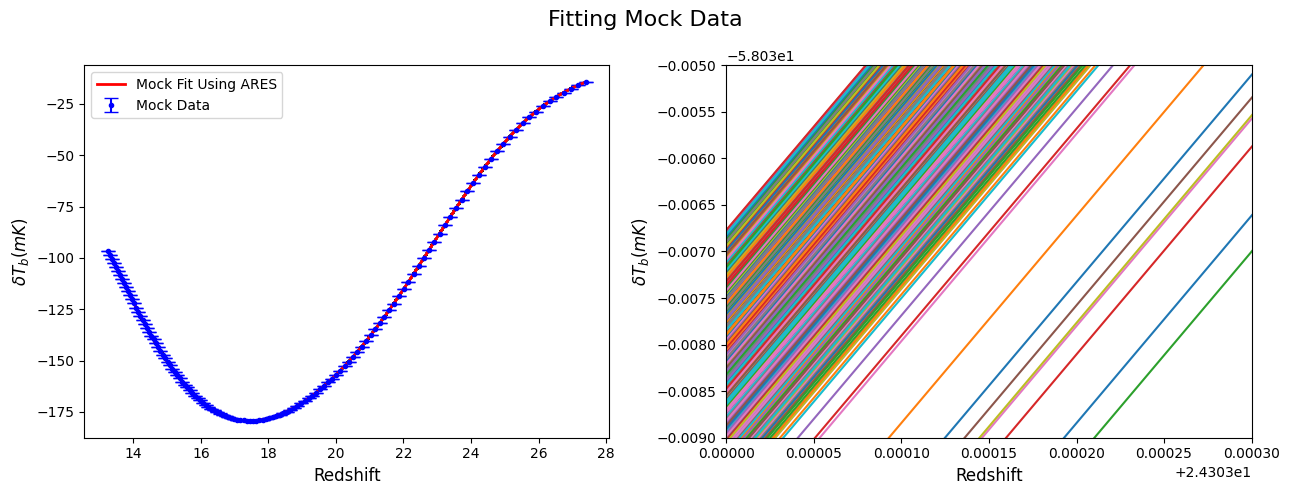

In [31]:
fig, ax_list = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Fitting Mock Data', fontsize=16)
for i in range(np.shape(mock_two)[0]):
    ax_list[0].plot(z_e, mock_two[i])
ax_list[0].set_xlabel('Redshift', fontsize=12)
ax_list[0].set_ylabel(r"$\delta T_b  \left(mK\right)$", fontsize=12)
ax_list[0].errorbar(z_e, true_curve_mock, yerr=noise_mock, fmt='.', label='Mock Data', capsize=5, color = 'blue')
ax_list[0].plot(z_e, fit_curve_mock, label='Mock Fit Using ARES', linewidth=2, color = 'red')
ax_list[0].legend()

for i in range(np.shape(mock_two)[0]):
    ax_list[1].plot(z_e, mock_two[i])
ax_list[1].set_xlabel('Redshift', fontsize=12)
ax_list[1].set_ylabel(r"$\delta T_b  \left(mK\right)$", fontsize=12)
ax_list[1].set_xlim(24.303, 24.3033)
ax_list[1].set_ylim(-58.039, -58.035)  
plt.tight_layout()
plt.savefig('fit_curve_mock.png')
plt.show()


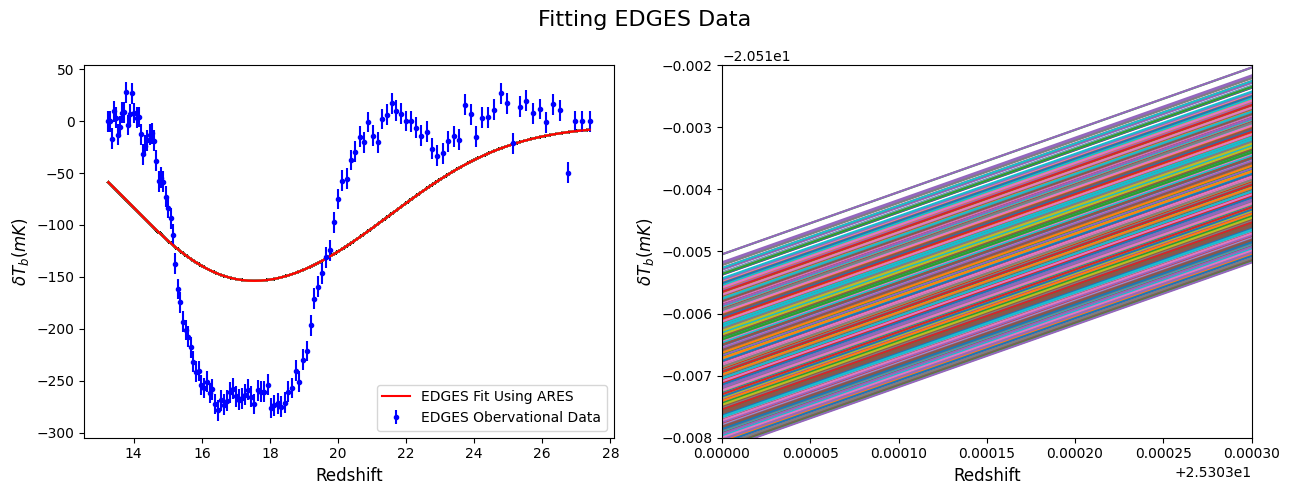

In [32]:
fig, ax_list = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Fitting EDGES Data', fontsize=16)
for i in range(np.shape(edges_one)[0]):
    ax_list[0].plot(z_e, edges_one[i])
ax_list[0].errorbar(z_e, data_e/2, yerr=noise_edges, fmt='.', label='EDGES Obervational Data', color='blue')
ax_list[0].plot(z_e, fit_curve_edges, label='EDGES Fit Using ARES', color='red')
ax_list[0].set_xlabel('Redshift', fontsize=12)
ax_list[0].set_ylabel(r"$\delta T_b  \left(mK\right)$", fontsize=12)
ax_list[0].legend()

for i in range(np.shape(edges_one)[0]):
    ax_list[1].plot(z_e, edges_one[i])
ax_list[1].set_xlabel('Redshift', fontsize=12)
ax_list[1].set_ylabel(r"$\delta T_b  \left(mK\right)$", fontsize=12)
ax_list[1].set_xlim(25.303, 25.3033)
ax_list[1].set_ylim(-20.518, -20.512)  
plt.tight_layout()
plt.savefig('fit_curve_edges.png')
plt.show()
